# Capstone Part 4.4 - Data Preprocessing / XGboost Modelling 

In [70]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt

In [71]:
combhotel_clean_df = pd.read_csv('combhotel_clean_df_v2.csv')

In [72]:
combhotel_clean_df.sample(3)

,hotel,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,IsCanceled,ADR_bin,got_assigned_room
77341,city hotel,21,2017,March,11,16,1,3,1,0,...,Transient-Party,70.0,0,0,Check-Out,2017-03-20,2017-03-16,False,51-100,True
77601,city hotel,40,2017,March,12,20,1,3,2,0,...,Contract,68.0,0,0,Check-Out,2017-03-24,2017-03-20,False,51-100,False
32105,resort hotel,150,2017,July,28,14,3,7,2,0,...,Transient,225.5,0,1,Check-Out,2017-07-24,2017-07-14,False,201-250,True


In [73]:
combhotel_clean_df.columns

Index(['hotel', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDate', 'IsCanceled', 'ADR_bin', 'got_assigned_room'],
      dtype='object')

In [74]:
numerical_columns = ['LeadTime', 'StaysInWeekendNights','StaysInWeekNights','Adults','Children',
                   'Babies','PreviousCancellations','PreviousBookingsNotCanceled', 'BookingChanges',
                   'DaysInWaitingList','ADR','RequiredCarParkingSpaces','TotalOfSpecialRequests']

binary_columns = ['IsCanceled', 'IsRepeatedGuest', 'got_assigned_room']

categorical_columns = ['hotel','Meal', 'Country', 'MarketSegment', 'DistributionChannel',
                       'ReservedRoomType', 'AssignedRoomType','DepositType', 'Agent', 'Company',
                       'CustomerType','ReservationStatus', 'ADR_bin']

date_not_datetime_columns = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber','ArrivalDateDayOfMonth']

datetime_columns = ['ReservationStatusDate','ArrivalDate']

# Preprocessing

Selecting feature columns

In [75]:
feature_cols = ['hotel','LeadTime', 'ArrivalDateMonth','StaysInWeekendNights', 'StaysInWeekNights','MarketSegment',
                'DistributionChannel','IsRepeatedGuest','CustomerType','ADR_bin','got_assigned_room']

cat_cols = ['hotel', 'ArrivalDateMonth','MarketSegment','DistributionChannel','CustomerType', 'ADR_bin']

binary_cols =  ['IsRepeatedGuest', 'got_assigned_room']

num_cols = ['LeadTime','StaysInWeekendNights','StaysInWeekNights']

In [76]:
combhotel_preprocess_df = combhotel_clean_df[feature_cols]

**one-hot encode**

In [77]:
for col in cat_cols:
    combhotel_preprocess_df = pd.concat([combhotel_preprocess_df,pd.get_dummies(combhotel_preprocess_df[col], prefix= col, drop_first= True)],axis = 1)

Dropping original category columns

In [78]:
combhotel_preprocess_df = combhotel_preprocess_df.drop(cat_cols,axis = 1)

In [79]:
combhotel_preprocess_df.columns

Index(['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights',
       'IsRepeatedGuest', 'got_assigned_room', 'hotel_resort hotel',
       'ArrivalDateMonth_August', 'ArrivalDateMonth_December',
       'ArrivalDateMonth_February', 'ArrivalDateMonth_January',
       'ArrivalDateMonth_July', 'ArrivalDateMonth_June',
       'ArrivalDateMonth_March', 'ArrivalDateMonth_May',
       'ArrivalDateMonth_November', 'ArrivalDateMonth_October',
       'ArrivalDateMonth_September', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Direct',
       'MarketSegment_Groups', 'MarketSegment_Offline TA/TO',
       'MarketSegment_Online TA', 'DistributionChannel_Direct',
       'DistributionChannel_GDS', 'DistributionChannel_TA/TO',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'ADR_bin_101-150', 'ADR_bin_151-200',
       'ADR_bin_201-250', 'ADR_bin_251-300', 'ADR_bin_301-350',
       'ADR_bin_351-400', 'ADR_bin_401-450', 'ADR_b

## train_test_split


In [80]:
X = combhotel_preprocess_df
y = combhotel_clean_df['IsCanceled']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

## weight imbalance handling with scale_pos_weight


In [82]:
count_neg = (y_train == 0).sum() 
count_pos = (y_train == 1).sum()
print(count_neg)
print(count_pos)

scale_pos_weight = count_neg/count_pos
print(scale_pos_weight)

50360
19189
2.624420240762937


## compare with baseline with no scale_pos_weight

In [119]:
xgb = XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    learning_rate=0.3,
    max_depth=5,
    random_state=42,
    eval_metric='logloss',
    # Adjusting class weights during training to boost minority class importance
    scale_pos_weight=1
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy = metrics.accuracy_score(y_test,y_pred)
recall = metrics.recall_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)

print(f'accuracy = {accuracy}')
print(f'recall = {recall}')
print(f'precision = {precision}')

accuracy = 0.7479871175523349
recall = 0.324577861163227
precision = 0.5768803260466839


## testing range of max_depth to achieve balance recall and precision score

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

In [161]:
recall_list = []
precision_list = []
for i in range (1,15):
    xgb = XGBClassifier(
    objective='binary:logistic',
    n_estimators=400,
    learning_rate=0.3,
    max_depth=i,
    random_state=42,
    eval_metric='logloss',
    reg_lambda = 10,
    scale_pos_weight=scale_pos_weight
    )
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    recall = metrics.recall_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred)

    recall_list.append(recall)
    precision_list.append(precision)

recall_df = pd.DataFrame({'maxdepth': range(1,15),'recall': recall_list})
precision_df = pd.DataFrame({'maxdepth': range(1,15),'precision': precision_list})
    

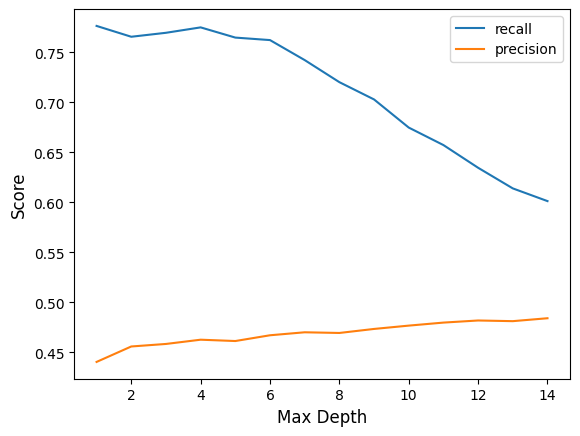

In [162]:
sns.lineplot(data=recall_df,x='maxdepth',y='recall', label = 'recall')
sns.lineplot(data=precision_df,x='maxdepth',y='precision', label='precision')
plt.legend()
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.show()

## Training a model using XGBoost with scale_pos_weight

In [165]:
xgb = XGBClassifier(
    objective='binary:logistic',
    n_estimators=400,
    learning_rate=0.3,
    max_depth=5,
    random_state=42,
    eval_metric='logloss',
    reg_lambda = 10,
    scale_pos_weight=scale_pos_weight
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

## model evaluation

In [166]:
accuracy = metrics.accuracy_score(y_test,y_pred)
recall = metrics.recall_score(y_test,y_pred)
precision = metrics.precision_score(y_test,y_pred)

print(f'accuracy = {accuracy}')
print(f'recall = {recall}')
print(f'precision = {precision}')

accuracy = 0.6885783298826778
recall = 0.7648530331457161
precision = 0.4611613876319759


## check if overfit

In [158]:
xgb = XGBClassifier(
    objective='binary:logistic',
    n_estimators=400,
    learning_rate=0.3,
    max_depth=5,
    random_state=42,
    eval_metric='logloss',
    reg_lambda = 10,
    scale_pos_weight=scale_pos_weight
)

xgb.fit(X_train, y_train)
y_pred_train = xgb.predict(X_train)

accuracy_train = metrics.accuracy_score(y_train,y_pred_train)
recall_train = metrics.recall_score(y_train,y_pred_train)
precision_train = metrics.precision_score(y_train,y_pred_train)

print(f'accuracy = {accuracy_train}')
print(f'recall = {recall_train}')
print(f'precision = {precision_train}')

accuracy = 0.7221958619103078
recall = 0.8265673041846892
precision = 0.4979280467131286


## Confusion matrix

In [146]:
from sklearn.metrics import confusion_matrix

In [155]:
cm = confusion_matrix(y_test, y_pred)

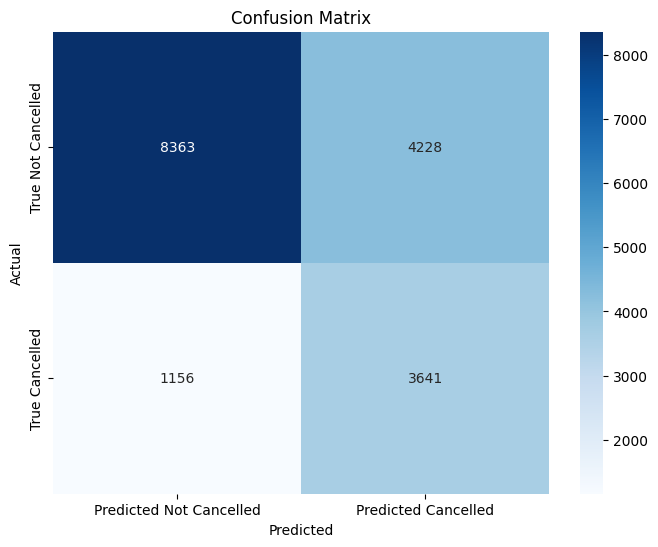

In [156]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Cancelled', 'Predicted Cancelled'], yticklabels=['True Not Cancelled', 'True Cancelled'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()